# Data Competition

- The goal of this project is to predict median house prices in California based on various socioeconomic and geographical factors. The competition evaluates models based on their predictive accuracy on an unseen test set.

- Objective: Train models to estimate house prices as accurately as possible.
- Evaluation Metric: Root Mean Squared Error (RMSE) or Mean Absolute Error (MAE).

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_decomposition import PLSRegression
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning) 


In [2]:
df = pd.read_csv(os.path.join("/kaggle/input/shrinkagedata", "housing.csv"), encoding='', sep=',', engine='python')
print("sample of data:", df.head())
print("variables:", df.columns)
print("number of observations:", len(df))


sample of data:    longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
variables: Index(['longitude', 'latitude', 'housing_median_

### We use the California Housing dataset from scikit-learn, which includes:

##### Features:

- median_income: Median income in the area
- housing_median_age: Median house age
- total_rooms: Average rooms per household
- total_bedrooms: Average bedrooms per household
- population: Population of the area
- households: number of households in the area
- ocean_proximity: whether close to ocean
- latitude: Geographical latitude
- longitude: Geographical longitude

##### Target Variable: 

median_house_value: (Median house price)

## Understanding Data

Before diving into preprocessing, a quick exploratory analysis is necessary.

In [3]:
print(df.shape)  # Print dimensions
print(df.info())  # Overview of data types
print(df.isnull().sum()) # Check missing

(20640, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0


In [28]:
# Drop missing or imputing missing values
df = df.dropna()

# Fill missing numerical values with median
#df.fillna(df.median(), inplace=True)

# Fill categorical missing values with mode
#df.fillna(df.mode().iloc[0], inplace=True)

In [29]:
# remove duplicates
df.drop_duplicates(inplace=True)

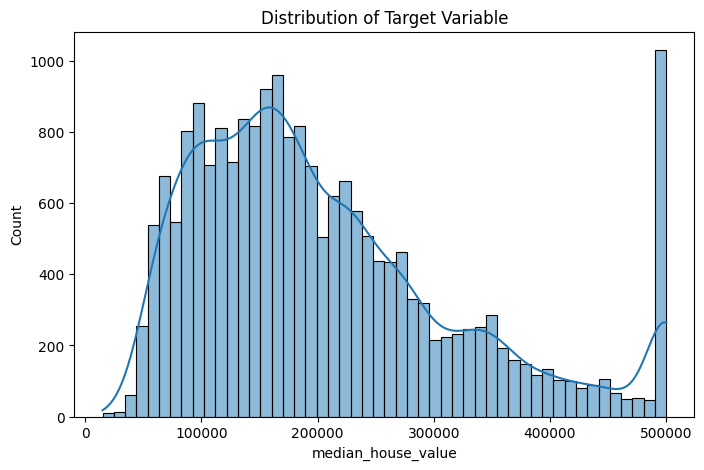

In [4]:
# Explore the distribution of target variable
# Helps detect outliers or skewed distribution.
# Use log transformation if the target variable is highly skewed.

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(df["median_house_value"], bins=50, kde=True)
plt.title("Distribution of Target Variable")
plt.show()

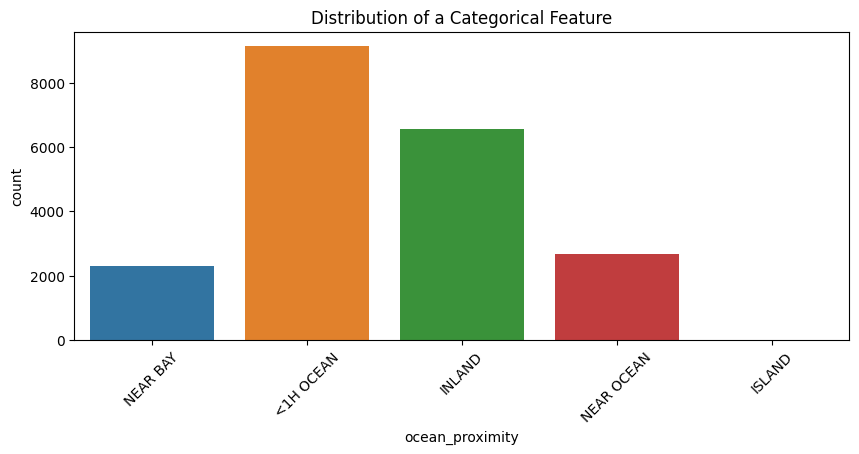

In [5]:
# Explore the distribution of category variable
plt.figure(figsize=(10, 4))
sns.countplot(x="ocean_proximity", data=df)
plt.title("Distribution of a Categorical Feature")
plt.xticks(rotation=45)
plt.show()


In [7]:
# Transform category variable to dummy
#df['inland']=(df['ocean_proximity'] == 'INLAND').astype(int) 
df = pd.get_dummies(df, columns=["ocean_proximity"], drop_first=True)  # One-hot encoding


In [9]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'],
      dtype='object')

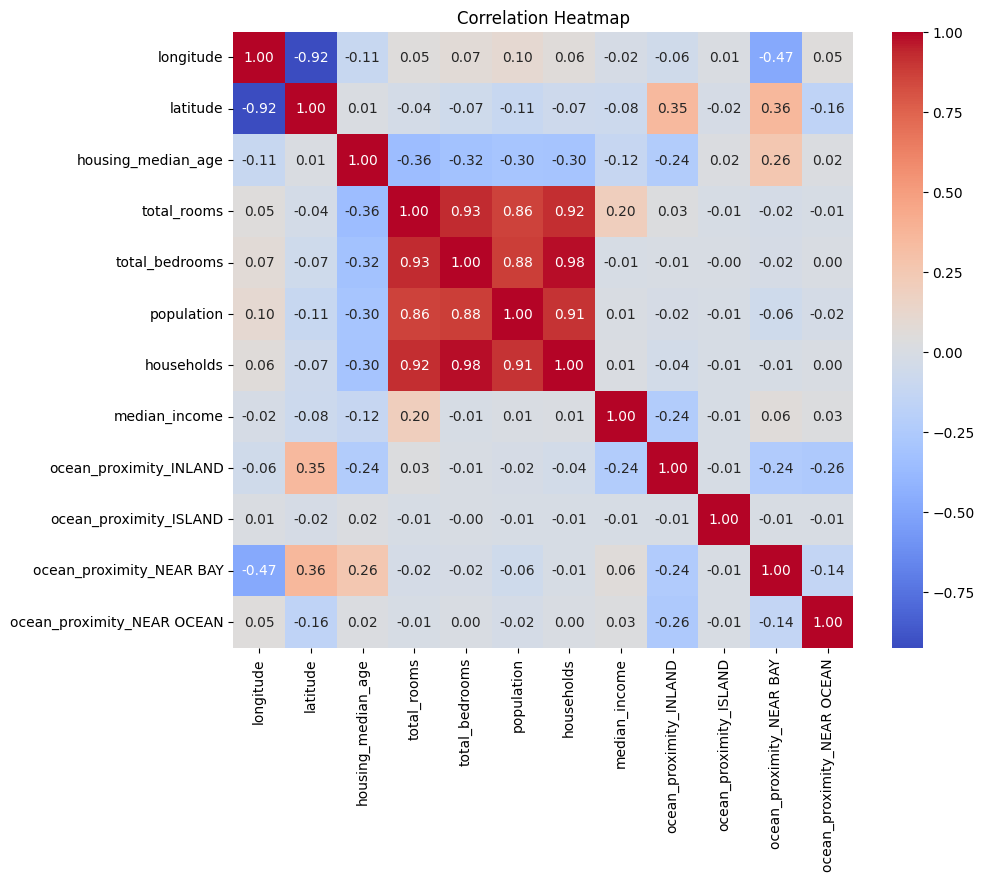

In [35]:
# check correlation among features
X = df.drop("median_house_value", axis=1)
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

#### Split data to working data and hold-out data

The purpose of splitting the data into a holdout sample and working data is to ensure a robust and unbiased evaluation of the final model. 

**Holdout Data (say 20%)**:

The holdout sample is kept aside and not used during the data preprocessing, feature engineering, or model development stages. It serves as an independent dataset to evaluate the final model.

Purpose of Holdout Data:
- Unbiased Evaluation: The holdout set is treated as unseen data, providing an unbiased estimate of how the model will perform on entirely new data.
- Simulating Real-World Scenarios: In real-world applications or competitions, the final model is tested on unseen data. The holdout sample mimics this situation.
- Preventing Data Leakage: By isolating the holdout sample, you ensure that none of its information leaks into the model during training or hyperparameter tuning.

**Working Data (80%)**:

The working data is used for all data preprocessing, feature engineering, and model development tasks. It is further split into training and validation sets to develop and evaluate models during the experimentation phase.

Purpose of Working Data:
- Model Training: The majority of the working data (typically 80% of the working data or 64% of the total data) is used to train the model.
- Model Validation: A smaller portion (typically 20% of the working data or 16% of the total data) is used to tune hyperparameters and validate the model's performance.
- Iterative Refinement: The working data allows you to experiment with preprocessing steps, feature engineering, and model selection without risking contamination of the holdout sample.

Why Not Use the Holdout Sample Early?

If you repeatedly evaluate models or preprocessing steps on the holdout sample:

- Overfitting to the Holdout Set: You inadvertently tune your model to perform well on the holdout set, leading to an overly optimistic estimate of generalization performance.
- Data Leakage: Preprocessing decisions made using the holdout data (e.g., scaling, imputation) can introduce information leakage into the model.
- Invalid Evaluation: The holdout sample loses its purpose as an independent evaluation set, making it impossible to fairly assess the final model.


In [10]:
# Split into holdout (20%) and working data (80%)
working_data, holdout_data = train_test_split(df, test_size=0.2, random_state=42)

# Model Development

In [38]:
from sklearn.metrics import mean_squared_error
X_working = working_data.drop("median_house_value", axis=1)
y_working = working_data["median_house_value"] / 100000
X_holdout = holdout_data.drop("median_house_value", axis=1)
y_holdout = holdout_data["median_house_value"] / 100000
# Feature enginerring
poly = PolynomialFeatures(degree=2, include_bias=False)
X_working_poly = poly.fit_transform(X_working)
X_holdout_poly = poly.fit_transform(X_holdout)

# Define Models 

In [30]:
# Define Models with Pipelines
linear_pipe = Pipeline([("model", LinearRegression())])

pcr_pipe = Pipeline([
    ("pca", PCA()),
    ("model", LinearRegression())
])

ridge_pipe = Pipeline([
    ("model", Ridge())  
])

lasso_pipe = Pipeline([
    ("model", Lasso())  
])

# Define Grid Search Parameter Grids
param_grid_pcr = {
    "pca__n_components": list(range(2, X_working_poly.shape[1] + 1))  # Tune PCA components
}

param_grid_ridge = {
    "model__alpha": [0.01, 0.1, 1, 10, 100]  # Tune Ridge regularization strength
}

param_grid_lasso = {
    "model__alpha": [0.01, 0.1, 1, 10, 100]  # Tune Lasso regularization strength
}

# Step 4: Run Cross-Validation for Each Model
grid_search_pcr = GridSearchCV(pcr_pipe, param_grid_pcr, cv=5, scoring="neg_mean_squared_error")
grid_search_ridge = GridSearchCV(ridge_pipe, param_grid_ridge, cv=5, scoring="neg_mean_squared_error")
grid_search_lasso = GridSearchCV(lasso_pipe, param_grid_lasso, cv=5, scoring="neg_mean_squared_error")

# Train Models
grid_search_pcr.fit(X_working_poly, y)
grid_search_ridge.fit(X_working_poly, y)
grid_search_lasso.fit(X_working_poly, y)
linear_pipe.fit(X_working_poly, y)  # No hyperparameters, so no GridSearch

# Step 5: Extract Best Parameters
best_n_components_pcr = grid_search_pcr.best_params_["pca__n_components"]
best_alpha_ridge = grid_search_ridge.best_params_["model__alpha"]
best_alpha_lasso = grid_search_lasso.best_params_["model__alpha"]

print(f"Optimal PCR Components: {best_n_components_pcr}")
print(f"Optimal Ridge Alpha: {best_alpha_ridge}")
print(f"Optimal Lasso Alpha: {best_alpha_lasso}")

# Step 6: Fit Final Models with Best Hyperparameters
pca_final = PCA(n_components=best_n_components_pcr)
X_working_pca = pca_final.fit_transform(X_working_poly)
X_holdout_pca = pca_final.transform(X_holdout_poly)

# Train Models on Entire Working Data
linear_final = LinearRegression()
pcr_final = LinearRegression()
ridge_final = Ridge(alpha=best_alpha_ridge)
lasso_final = Lasso(alpha=best_alpha_lasso)

linear_final.fit(X_working_poly, y_working)
pcr_final.fit(X_working_pca, y_working)
ridge_final.fit(X_working_poly, y_working)
lasso_final.fit(X_working_poly, y_working)

# Evaluate on Holdout Test Set
y_pred_linear = linear_final.predict(X_holdout_poly)
y_pred_pcr = pcr_final.predict(X_holdout_pca)
y_pred_ridge = ridge_final.predict(X_holdout_poly)
y_pred_lasso = lasso_final.predict(X_holdout_poly)

rmse_linear = np.sqrt(mean_squared_error(y_holdout, y_pred_linear))
rmse_pcr = np.sqrt(mean_squared_error(y_holdout, y_pred_pcr))
rmse_ridge = np.sqrt(mean_squared_error(y_holdout, y_pred_ridge))
rmse_lasso = np.sqrt(mean_squared_error(y_holdout, y_pred_lasso))

0.6650247359917456


# Lasso Regression

In [31]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_poly,y_train)
test_score=lasso.score(X_test_poly,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print(test_score)
print(lasso.coef_)

-24.388334282122702
[-0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.98187421e-02 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.77960043e-02
 -0.00000000e+00 -1.49127318e-01 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.07104310e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.0

# Ridge regression

In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=5)
ridge.fit(X_train_poly,y_train)
test_score=ridge.score(X_test_poly,y_test)
print(test_score)


# Elastic net

In [ ]:
from sklearn.linear_model import ElasticNet
elas = ElasticNet(alpha=0.005, l1_ratio=0.5)
elas.fit(X_train_poly, y_train)
test_score=elas.score(X_test_poly,y_test)
print(test_score)


# Using K-fold cross validation (k=10) to tune the hyper parameter in Lasso regression

In [ ]:
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = np.arange(0.0001, 1, 0.01)
grid['l1_ratio'] = np.arange(0.0001, 1, 0)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
#results = search.fit(X_train_poly, y)
# summarize
#print('MAE: %.3f' % results.best_score_)
#print('Config: %s' % results.best_params_)

# Using K-fold cross validation to tune the two hyper parameters in elastic net

In [ ]:
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = np.arange(0.001, 1, 0.2)
grid['l1_ratio'] = np.arange(0, 1, 0.2)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
#results = search.fit(xmat, y)
# summarize
#print('MAE: %.3f' % results.best_score_)
#print('Config: %s' % results.best_params_)

An illustration of K-fold cross-validation

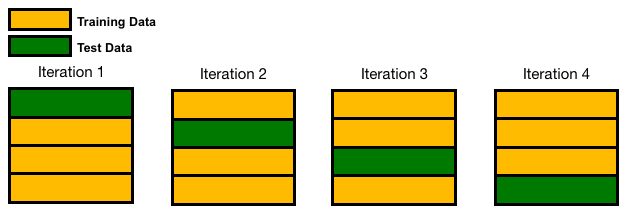!

# Codes implementing K-fold cross validation from scratch

In [ ]:
from sklearn.utils import shuffle
def cross_validation_split(df, folds):
    df_copy = df.copy()
    group_size = int(df_copy.shape[0] / folds)
        
    # re-ordering rows of data set randomly
    df_copy = shuffle(df_copy)
    lst = [df_copy.iloc[i:i+group_size] for i in range(0,len(df_copy),group_size)]
    if len(lst[-1]) < group_size:
        lst.pop()
    return lst 

def lasso_cv(data_groups, alpha_test):
    lasso = Lasso(alpha=alpha_test)
    scores = []
    for i in range(len(data_groups)):
        data_copy = data_groups.copy()
        test_data = data_copy[i]
        X_test = test_data[X_list]
        y_test = test_data['Price']
        data_copy.pop(i)
        training_data = pd.concat(data_copy)
        X_train = training_data[X_list] 
        y_train = training_data['Price']
        lasso.fit(X_train,y_train)
        test_score=lasso.score(X_test,y_test)
        scores.append(test_score)
    return scores


# Example of using Least Angel Regressin to implement Lasso


In [ ]:
from sklearn.linear_model import LassoLars
model = LassoLars(alpha=0.01)
model.fit(X_train, y_train)
test_score = model.score(X_test, y_test)
model.coef_

# Examples of implementing principle component regression (PCR)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# first normalize data
sc = StandardScaler()
x = sc.fit_transform(xmat)

# now run PCA on the normalized data
pca = PCA(n_components = 8)
X_reduced = pca.fit_transform(x)
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

# Now we try to develop a regression model on the components
X_train,X_test,y_train,y_test=train_test_split(X_reduced,y,test_size=0.2,random_state=3)
reg = LinearRegression()
reg.fit(X_train, y_train)
test_score=reg.score(X_test,y_test)
print(test_score)

# Example of Partial Least Squares in Python

In [ ]:
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression(n_components=8)
pls.fit(X_train, y_train)
pls.score(X_test, y_test)